In [1]:
import scipy
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn import preprocessing

In [2]:
def save_array_to_nifti1(array, original_img, destination_path, output_name):
    # Transform the array to a nifti image which requires the affine of the original image.
    processed_img = nib.Nifti1Image(array, original_img.affine)
    nib.save(processed_img, os.path.join(destination_path, output_name))

In [3]:
def Stroke_closing(img):
    # used to close stroke prediction image
    new_img = np.zeros_like(img)
    new_img = scipy.ndimage.binary_closing(img, structure=np.ones((2,2,2)))
    return new_img

In [4]:
def z_score_normalize_saturate_outliers(array, quantile_of_max=1.0):
    # Z_score normalizing with error handling and binning of outliers at the max of the
    # specified quantile.
    saturation_value = np.quantile(array, quantile_of_max)
    array[array >= saturation_value] = saturation_value
    
    if np.std(array) != 0.0:
        return (array-np.mean(array))/np.std(array)
    else:
        return array

In [14]:
def get_SkullStripped_Mask(model, SWI_img, TOF_img):
    # To inference brain mask from MaskNet model
    # model specifies which pre-trained DL model is used to inference
    
    # Down sampling
    swi = SWI_img[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

    tof = TOF_img[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

    # swi_background_value = -np.mean(swi)/np.std(swi)
    # tof_background_value = -np.mean(tof)/np.std(tof)
    
    swi  = z_score_normalize_saturate_outliers(swi)
    tof  = z_score_normalize_saturate_outliers(tof)

    # swi[swi == swi_background_value] = 0
    # tof[tof == tof_background_value] = 0
    
    x = np.expand_dims(np.concatenate((swi,tof),axis=3), axis=0)

    # Standardize x before input into the neural network.
    # dim_1, dim_2, dim_3, dim_4, dim_5 = x.shape
    # robust_scaler = preprocessing.RobustScaler()
    # x_rescaled = standard_scaler.fit_transform(x.reshape(dim_2,-1)).reshape(dim_1,dim_2,dim_3,dim_4,dim_5)
    
    # inference
    y_pred = model.predict(x, verbose=0)
    y_pred = (np.squeeze(y_pred)>0.5)*1.0

    
    # the following is post processing of predicted mask by 
    # 1) selecting the major non-zero voxel
    # 2) closing
    # 3) binary fill holes
    # 4) upsampling to high resolution space by (4,4,4)
    
    mask_label, num_features = scipy.ndimage.label(y_pred)
    dilate_mask = (mask_label == scipy.stats.mode(mask_label[mask_label>0].flatten(), keepdims=True)[0][0])*1
    dilate_mask = Stroke_closing(dilate_mask)
    dilate_mask = scipy.ndimage.binary_fill_holes(dilate_mask)
    upsampling_mask = np.repeat(np.repeat(np.repeat(dilate_mask, 4, axis=0), 4, axis=1), 4, axis=2)

    return upsampling_mask

In [6]:
def apply_skullstripping(model, SWI_folder_path, TOF_folder_path, mask_destination_path, swi_img_destination_path, tof_img_destination_path):
    swi_files = os.listdir(SWI_folder_path)
    tof_files = os.listdir(TOF_folder_path)

    # Select files to process.
    swi_nifti_files = [file for file in swi_files if file.endswith('.nii.gz')]
    tof_nifti_files = [file for file in tof_files if file.endswith('.nii.gz')]

    for swi_file, tof_file in zip(swi_nifti_files, tof_nifti_files):
        swi_file_path = os.path.join(SWI_folder_path, swi_file)
        tof_file_path = os.path.join(TOF_folder_path, tof_file)
        swi_nii_img = nib.load(swi_file_path)
        swi_nii_data = swi_nii_img.get_fdata()
        tof_nii_img = nib.load(tof_file_path)
        tof_nii_data = tof_nii_img.get_fdata()

        mask_name = os.path.splitext(os.path.splitext(swi_file)[0])[0] + "_" + "Mask" + ".nii.gz"
        new_swi_img_name = os.path.splitext(os.path.splitext(swi_file)[0])[0] + "_" + "SkullStripped" + ".nii.gz"
        new_tof_img_name = os.path.splitext(os.path.splitext(tof_file)[0])[0] + "_" + "SkullStripped" + ".nii.gz"

        mask_data_bool = get_SkullStripped_Mask(model, swi_nii_data, tof_nii_data)
        mask_data = mask_data_bool.astype("float64")
        save_array_to_nifti1(mask_data, swi_nii_img, mask_destination_path, mask_name)
        
        skullstripped_swi_data = mask_data * swi_nii_data
        skullstripped_tof_data = mask_data * tof_nii_data

        save_array_to_nifti1(skullstripped_swi_data, tof_nii_img, swi_img_destination_path, new_swi_img_name)
        save_array_to_nifti1(skullstripped_tof_data, swi_nii_img, tof_img_destination_path, new_tof_img_name)
        
        print(f"Processed SWI image {swi_file} and TOF image {tof_file}")

In [7]:
MaskNet_name =  os.path.join("D:\ADS_Algorithm\ADSv1.3\data\Trained_Nets", 'BrainMaskNet.h5')

In [8]:
MaskNet = load_model(MaskNet_name, compile=False)

In [ ]:
apply_skullstripping(MaskNet, "D:\\data_processed_ETIS\\Resized_Images\\SWI", "D:\\data_processed_ETIS\\Resized_Images\\TOF3D", "D:\\data_processed_ETIS\\SkullStripped_Images\\Brain_Mask_zscore_saturated", "D:\\data_processed_ETIS\\SkullStripped_Images\\SkullStripped_SWI_zscore_saturated", "D:\\data_processed_ETIS\\SkullStripped_Images\\SkullStripped_TOF3D_zscore_saturated")

In [15]:
apply_skullstripping(MaskNet, "D:\\pythonscripts_ETIS\\SkullStripping_Check\\SWI_Resized", "D:\\pythonscripts_ETIS\\SkullStripping_Check\\TOF3D_Resized", "D:\\pythonscripts_ETIS\\SkullStripping_Check\\Brain_Mask_zscore_saturated", "D:\\pythonscripts_ETIS\\SkullStripping_Check\\SkullStripped_SWI_zscore_saturated", "D:\\pythonscripts_ETIS\\SkullStripping_Check\\SkullStripped_TOF3D_zscore_saturated")

Processed SWI image 2018-104_02-10241-D0MR_701_SWIp_50s_.nii.gz and TOF image 2018-104_02-10241-D0MR_401_TOF_MC4_0.8x1.3_.nii.gz
Processed SWI image 2018-104_02-10420-D0MR_5_Ax_SWAN_.nii.gz and TOF image 2018-104_02-10420-D0MR_6_3D_TOF_ENTIER_.nii.gz
Processed SWI image 2018-104_02-10428-D0MR_801_SWIp_50s_.nii.gz and TOF image 2018-104_02-10428-D0MR_501_TOF_MC4_0.8x1.3_.nii.gz
Processed SWI image 2018-104_02-10508-D0MR_9_Ax_eSWAN_2017_.nii.gz and TOF image 2018-104_02-10508-D0MR_5_3D_TOF_1910_.nii.gz
Processed SWI image 2018-104_02-10556-D0MR_801_SWIp_50s_.nii.gz and TOF image 2018-104_02-10556-D0MR_501_TOF_MC4_0.8x1.3_.nii.gz
Processed SWI image 2018-104_02-10596-D0MR_13_AX_T2_EG_fl2d1r.nii.gz and TOF image 2018-104_02-10596-D0MR_8_3D_TOF_CS_fl3d1r.nii.gz
Processed SWI image 2018-104_02-10619-D0MR_13_AX_T2_EG_fl2d1r.nii.gz and TOF image 2018-104_02-10619-D0MR_8_3D_TOF_CS_fl3d1r.nii.gz
Processed SWI image 2018-104_02-10639-D0MR_6_Ax_T2_GRE_.nii.gz and TOF image 2018-104_02-10639-D0MR_5

In [14]:
swi_nii_img = nib.load("D:\\pythonscripts_ETIS\\Test_SWI\\2018-104_01-10087-D0MR_12_SWI_Images_swi3d1r.nii.gz")
swi_nii_data = swi_nii_img.get_fdata()
tof_nii_img = nib.load("D:\\pythonscripts_ETIS\\Test_TOF\\2018-104_01-10087-D0MR_8_TOF_3D_NEW_wo_ARTEFACTS_fl3d1r_t50.nii.gz")
tof_nii_data = tof_nii_img.get_fdata()

In [11]:
swi_nii_img_norm = nib.load("D:\\pythonscripts_ETIS\\Test_SWI_norm\\2018-104_01-10087-D0MR_12_SWI_Images_swi3d1r_Normalized.nii.gz")
swi_nii_data_norm = swi_nii_img_norm.get_fdata()
tof_nii_img_norm = nib.load("D:\\pythonscripts_ETIS\\Test_TOF_Norm\\2018-104_01-10087-D0MR_8_TOF_3D_NEW_wo_ARTEFACTS_fl3d1r_t50_Normalized.nii.gz")
tof_nii_data_norm = tof_nii_img_norm.get_fdata()

In [29]:
mask_data = get_SkullStripped_Mask(MaskNet, swi_nii_data_norm, tof_nii_data_norm)

In [30]:
skullstripped_swi_data = mask_data * swi_nii_data

In [31]:
save_array_to_nifti1(mask_data.astype("float64"), swi_nii_img, "D:\\pythonscripts_ETIS", "test_mask.nii.gz")

In [32]:
save_array_to_nifti1(skullstripped_swi_data, swi_nii_img, "D:\\pythonscripts_ETIS", "test_swi_skullstripped.nii.gz")

In [35]:
swi = swi_nii_data[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]
tof = tof_nii_data[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]
x = np.expand_dims(np.concatenate((swi,tof),axis=3), axis=0)

In [58]:
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x.reshape(48,-1)).reshape(1,48,56,48,2)

In [59]:
x_scaled.shape

(1, 48, 56, 48, 2)

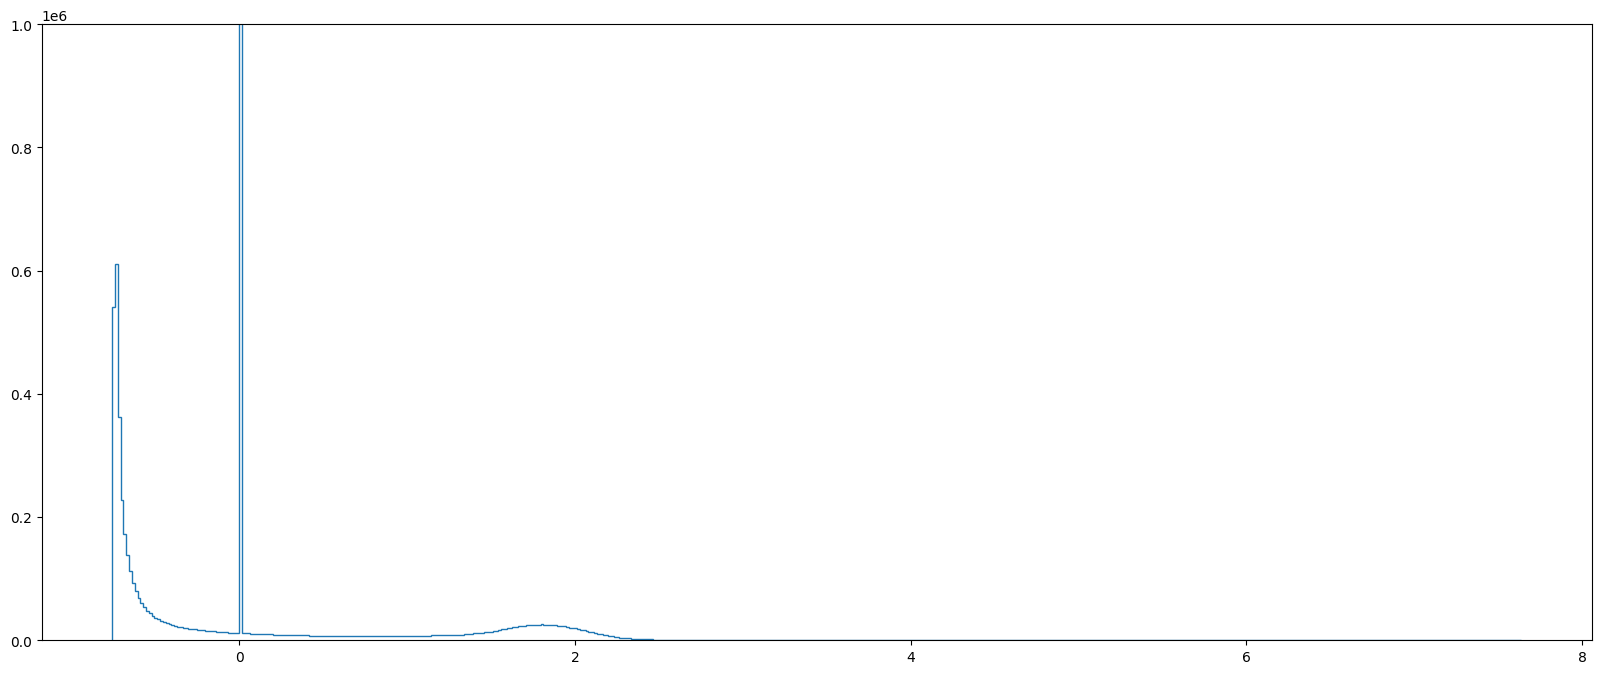

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_nii_data_norm.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [15]:
swi_nii_data.shape

(192, 224, 192)

In [16]:
standard_scaler = preprocessing.StandardScaler()
swi_standard_scaled = standard_scaler.fit_transform(swi_nii_data.reshape(192,-1)).reshape(192,224,192)

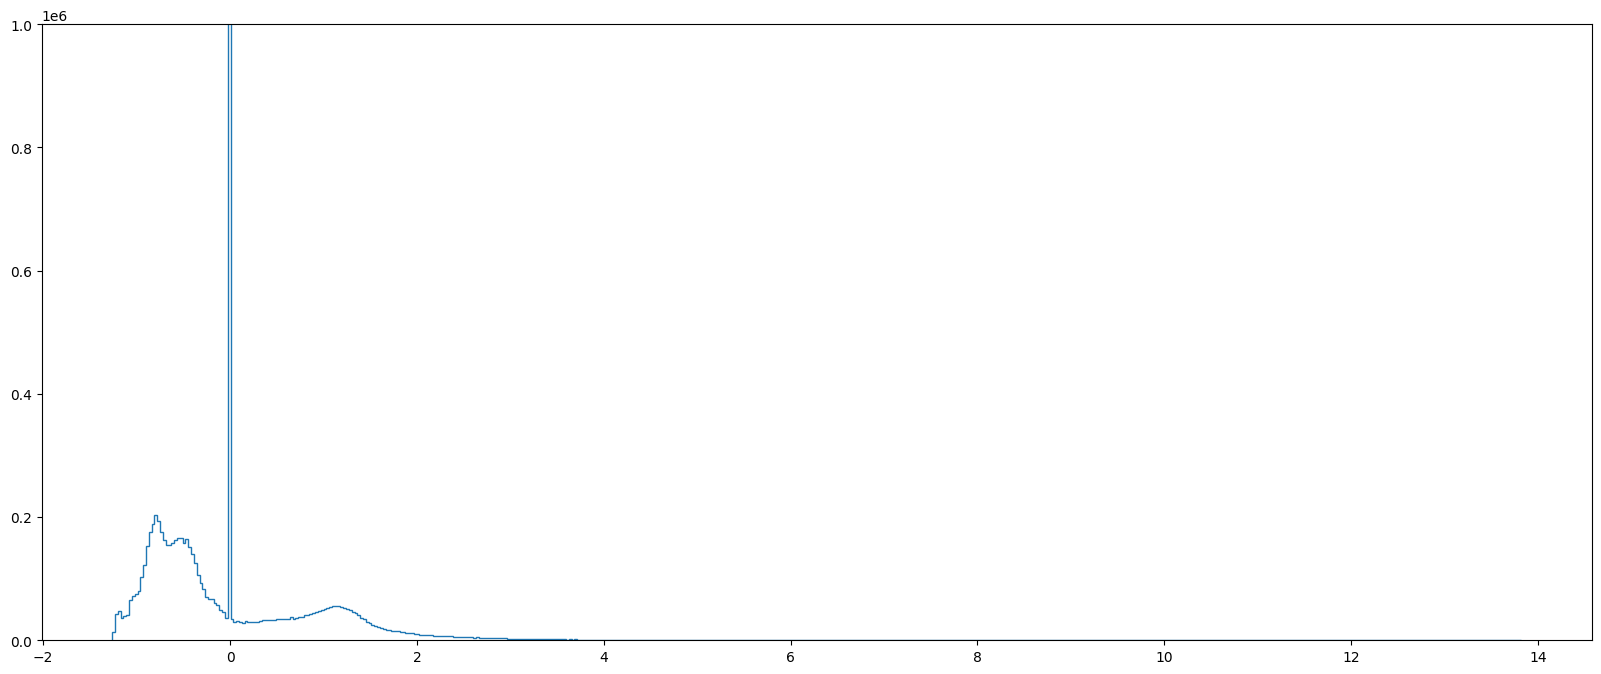

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_standard_scaled.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [18]:
swi_manual_scaled = (swi_nii_data-np.mean(swi_nii_data))/np.std(swi_nii_data)

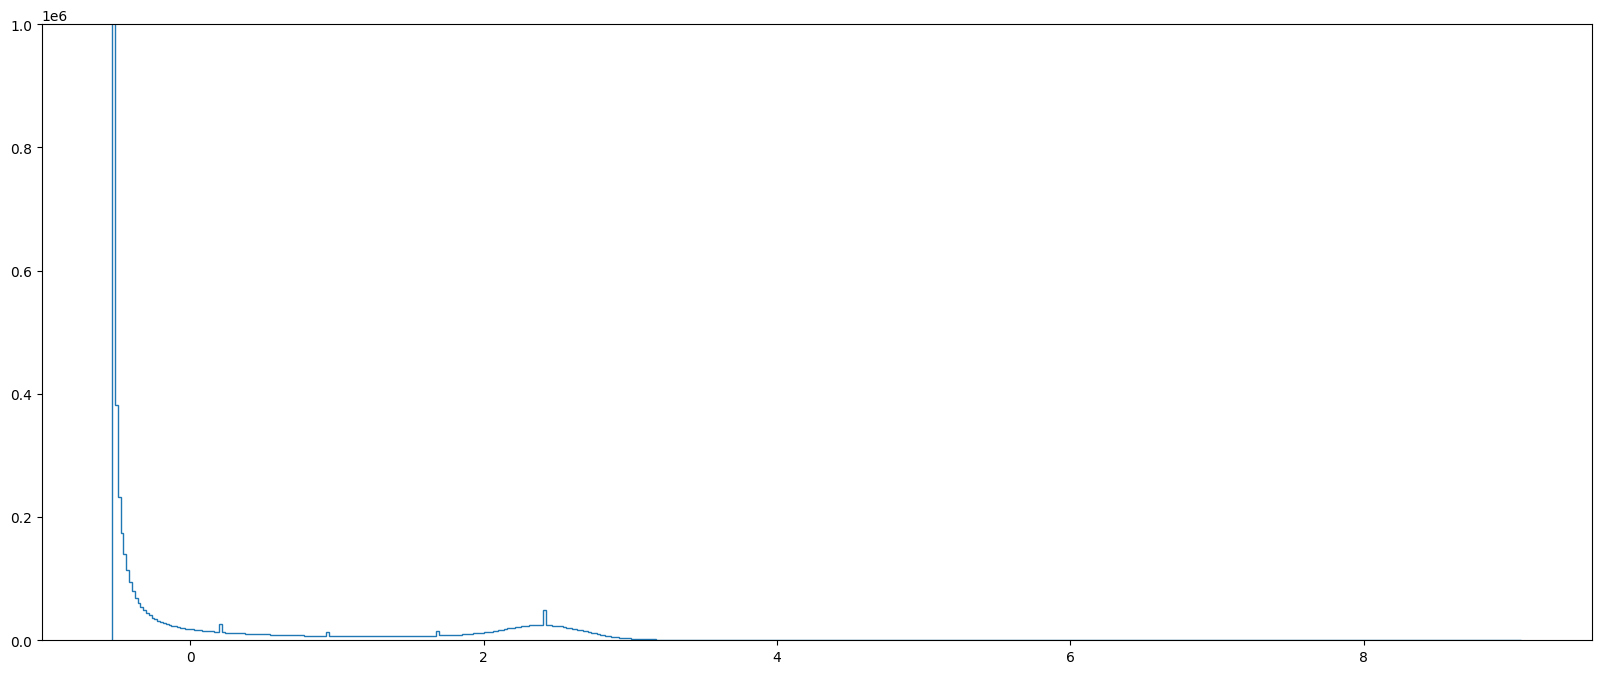

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_manual_scaled.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [52]:
swi_manual_scaled_mean_is_background = (swi_nii_data-0)/np.std(swi_nii_data)

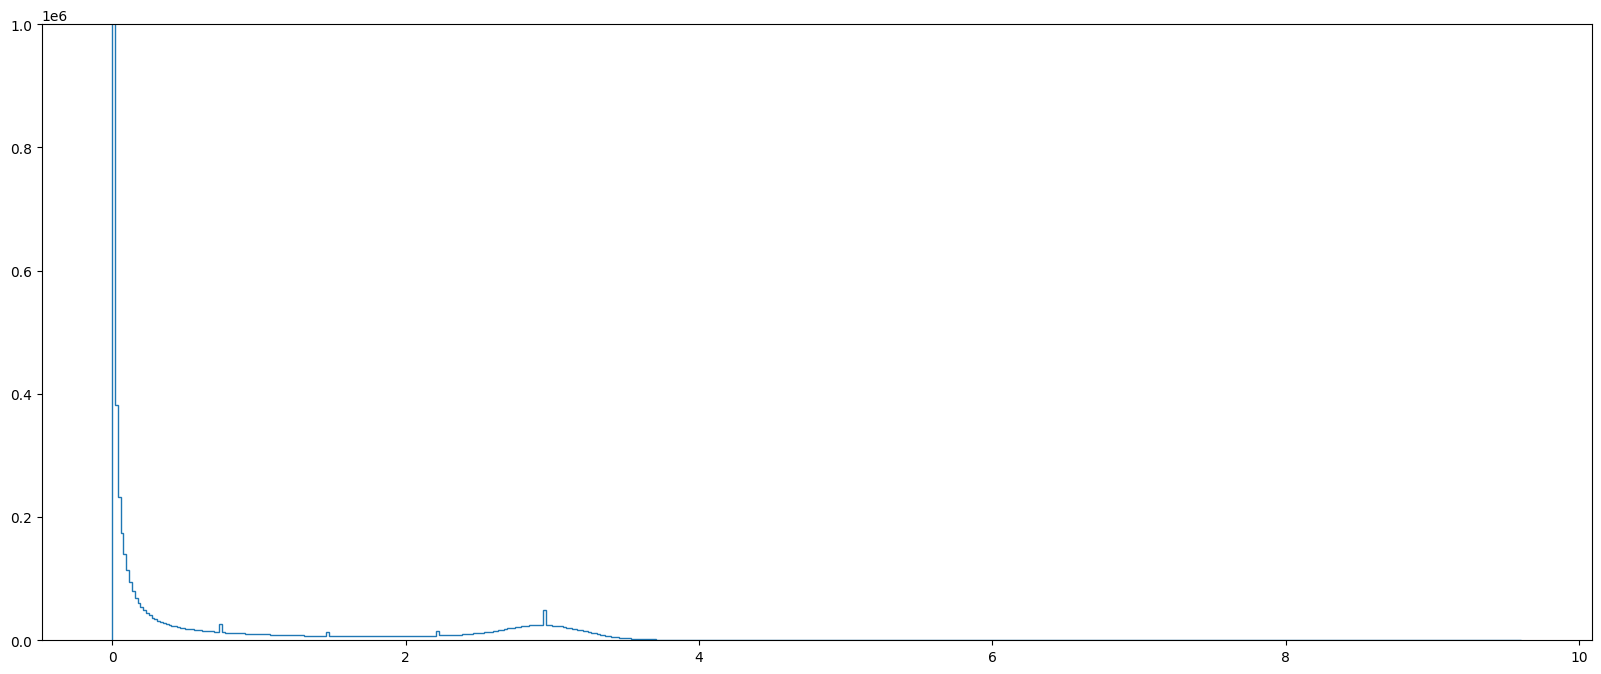

In [53]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_manual_scaled_mean_is_background.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [47]:
swi_background_value = -np.mean(swi_nii_data)/np.std(swi_nii_data)
swi_manual_scaled_background_shifted = swi_manual_scaled.copy()
swi_manual_scaled_background_shifted[swi_manual_scaled_background_shifted == swi_background_value] = 0

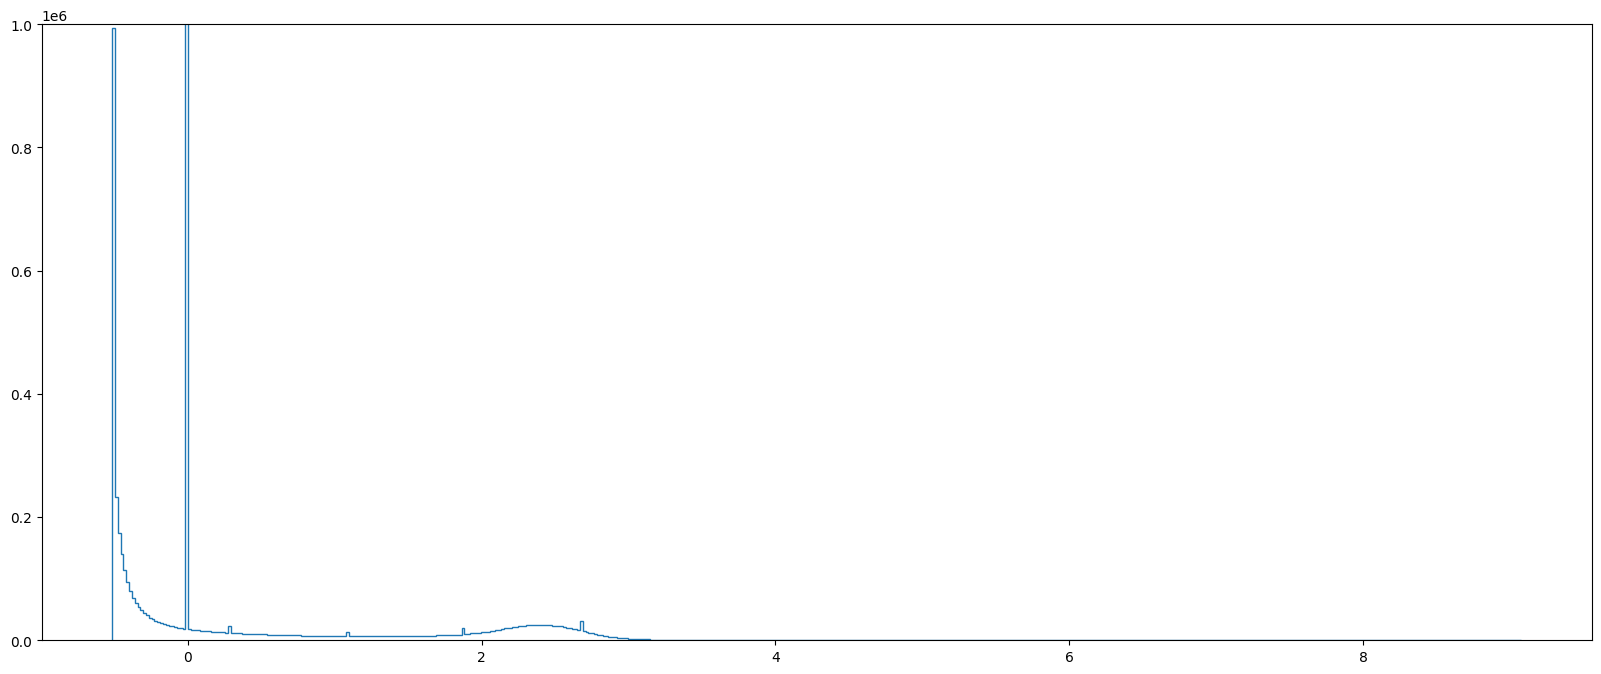

In [48]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_manual_scaled_background_shifted.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [33]:
dim_1, dim_2, dim_3 = swi_nii_data.shape
swi_reshaped_2d = swi_nii_data.reshape(dim_1,-1)
std_vector = np.std(swi_reshaped_2d, axis=0)
std_vector[std_vector == 0] = 1

In [38]:
swi_manual_scaled_by_axis_2d = (swi_reshaped_2d-np.mean(swi_reshaped_2d, axis=0))/std_vector
swi_manual_scaled_by_axis = swi_manual_scaled_by_axis_2d.reshape(dim_1,dim_2,dim_3)

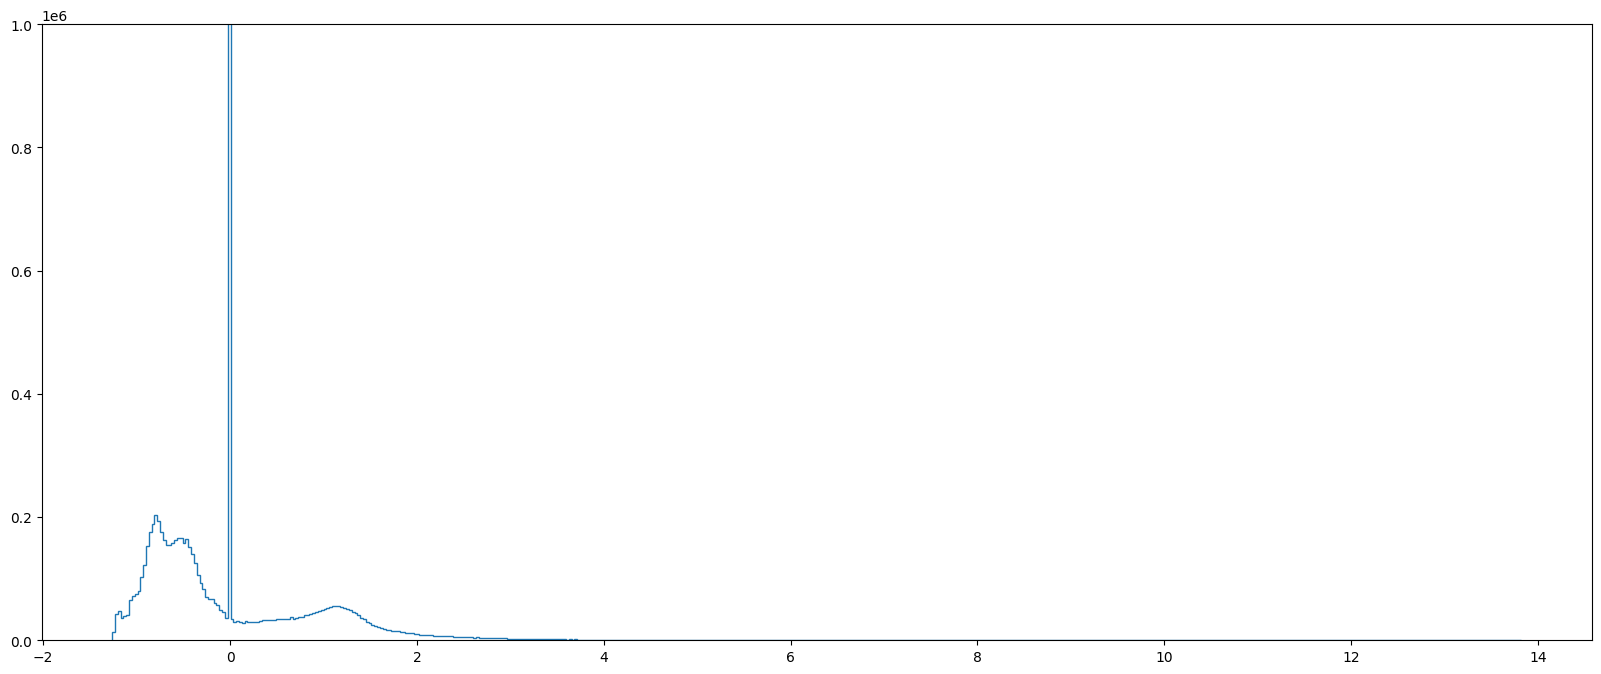

In [40]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_manual_scaled_by_axis.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

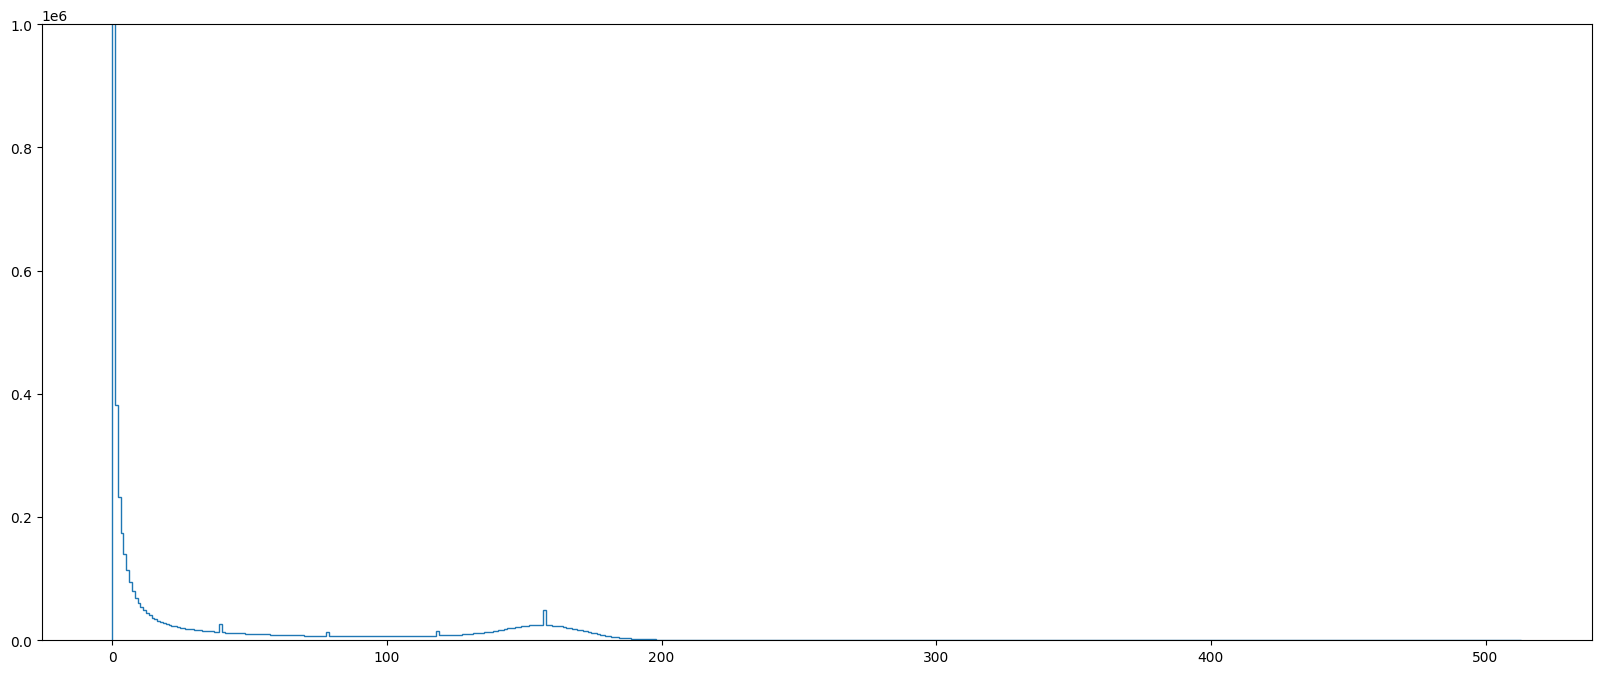

In [44]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_nii_data.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()

In [61]:
z_mu = np.sum(swi_nii_data.flatten())/len(swi_nii_data.flatten())
z_sigma = np.sqrt(np.sum(np.power(swi_nii_data - z_mu,2))/(len(swi_nii_data.flatten())-1))

In [64]:
swi_z_score = (swi_nii_data - z_mu)/z_sigma

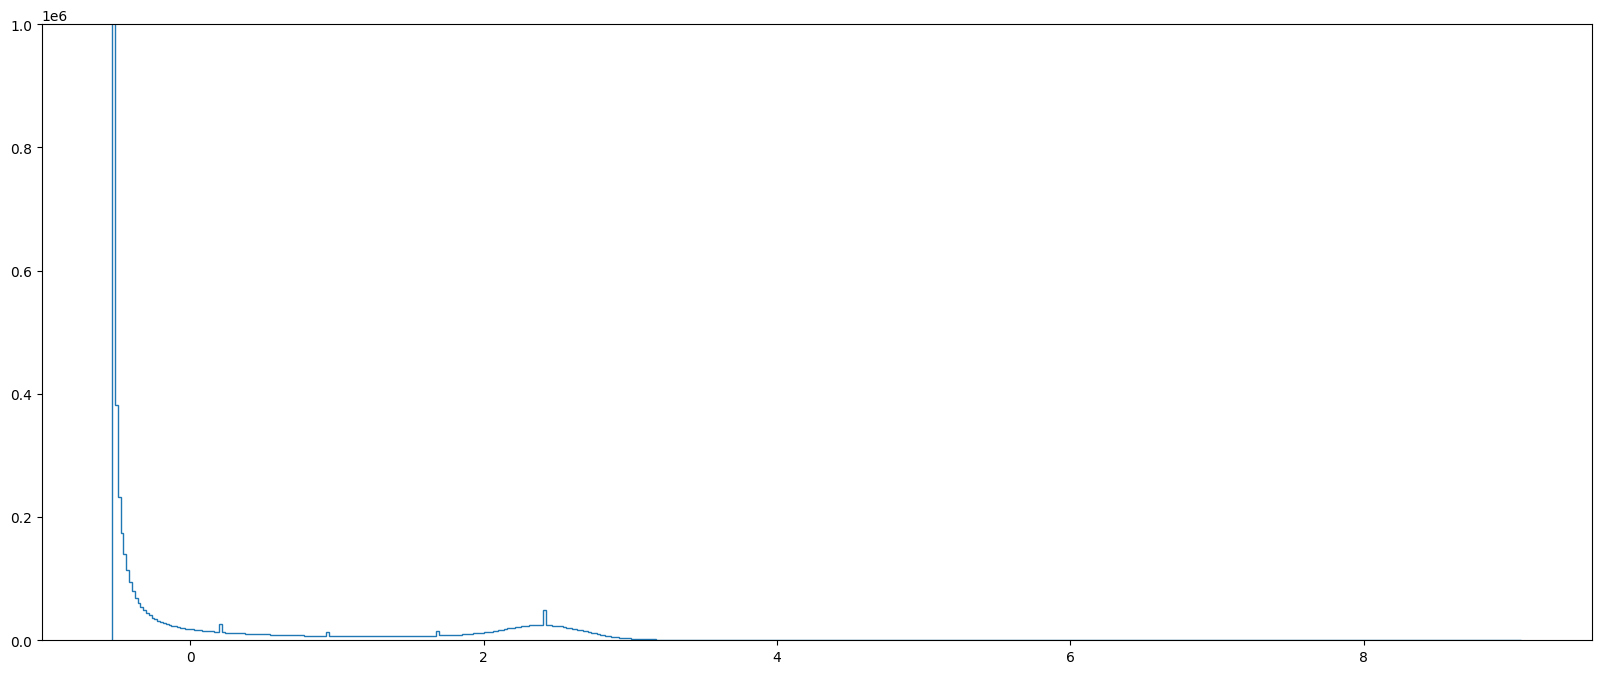

In [65]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(swi_z_score.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,1000000)
plt.show()